In [1]:
%%capture
import torch

# 1. Önce PyTorch versiyonunu sabitleyelim (Gereksiz güncellemeyi önler)
# Colab'de zaten Torch yüklü, sadece Unsloth'u buna uyduracağız.

# 2. Unsloth'u Ana Paket Olarak Kur
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# 3. Kritik Kütüphaneleri BAĞIMSIZ Kur (no-deps hayat kurtarır)
# Bu komut pip'in "versiyon hesaplama" süresini 0'a indirir.
!pip install --no-deps xformers trl peft accelerate bitsandbytes

# 4. Son olarak Transformers'ı güvenli sürüme çek
!pip install --no-deps --upgrade "transformers>=4.43.2"

In [2]:
import torch
from trl import SFTTrainer
from unsloth import FastLanguageModel

print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
print("✅ TRL ve Unsloth kuruldu, eğitime hazırsın!")

/tmp/ipython-input-3744757883.py:3: UserWarning: WARNING: Unsloth should be imported before [trl, transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ GPU: NVIDIA A100-SXM4-40GB
✅ TRL ve Unsloth kuruldu, eğitime hazırsın!


In [3]:
import json
import random

# Dosya yolu (Önceki adımda oluşturduğumuz fixed/ready dosya)
input_file = 'mat_sorulari_fixed.json'

def split_dataset(file_path, train_count=400, test_count=100):
    print(f"✂️  Veri Seti Bölünüyor: {file_path}...")

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        total_questions = len(data)
        print(f"   📊 Toplam Soru Sayısı: {total_questions}")

        # Yeterli veri var mı kontrolü
        if total_questions < (train_count + test_count):
            print(f"   ⚠️ UYARI: İstenen toplam sayı ({train_count + test_count}), eldeki veriden ({total_questions}) fazla!")
            print("   Mevcut verinin %80'i eğitim, %20'si test olarak ayarlanıyor...")
            # Otomatik oranlama (eğer sayı yetmezse)
            train_count = int(total_questions * 0.8)
            test_count = total_questions - train_count

        # Rastgele karıştır (Her çalıştırmada farklı set oluşsun)
        random.shuffle(data)

        # Bölme işlemi (Slicing)
        train_data = data[:train_count]
        test_data = data[train_count : train_count + test_count]

        # Dosyaları Kaydet
        with open('mat_train.json', 'w', encoding='utf-8') as f:
            json.dump(train_data, f, ensure_ascii=False, indent=2)

        with open('mat_test.json', 'w', encoding='utf-8') as f:
            json.dump(test_data, f, ensure_ascii=False, indent=2)

        print(f"   ✅ İŞLEM TAMAMLANDI!")
        print(f"   📂 Eğitim Seti: mat_train.json ({len(train_data)} soru)")
        print(f"   📂 Test Seti  : mat_test.json  ({len(test_data)} soru)")

    except FileNotFoundError:
        print(f"❌ Dosya bulunamadı: {file_path}. Lütfen dosya adını kontrol edin.")
    except Exception as e:
        print(f"❌ Bir hata oluştu: {e}")

# Fonksiyonu çalıştır
split_dataset(input_file)

✂️  Veri Seti Bölünüyor: mat_sorulari_fixed.json...
   📊 Toplam Soru Sayısı: 525
   ✅ İŞLEM TAMAMLANDI!
   📂 Eğitim Seti: mat_train.json (400 soru)
   📂 Test Seti  : mat_test.json  (100 soru)


In [1]:
# --- 1. Önce Unsloth Import Edilmeli ---
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import load_dataset
import gc

# Hafıza Temizliği (Garanti olsun)
gc.collect()
torch.cuda.empty_cache()

# --- 2. AYARLAR ---
max_seq_length = 2048
model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"

# --- 3. MODELİ YÜKLE ---
print(f"🔄 Model Yükleniyor: {model_name}...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = None,
    load_in_4bit = True,
)

# LoRA Adaptörleri
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

# --- 4. VERİ FORMATLAMA (Düzeltilmiş Fonksiyon) ---
prompt_template = """Aşağıdaki matematik sorusunu adım adım düşünerek çöz ve doğru seçeneği belirt.

### Soru:
{}

### Seçenekler:
{}

### Çözüm ve Cevap:
{}
Doğru Cevap: {}""" + tokenizer.eos_token

def formatting_prompts_func(examples):
    questions = examples["question"]
    options_lists = examples["options"]
    rationales = examples["rationale"]
    corrects = examples["correct"]
    texts = []

    for q, opts, rat, corr in zip(questions, options_lists, rationales, corrects):
        # Hata önleyici: Liste değilse string yap
        if not isinstance(opts, list):
            opts_str = str(opts) if opts is not None else ""
        else:
            try:
                opts_str = "\n".join([str(x) for x in opts])
            except:
                opts_str = str(opts)

        q = str(q) if q else ""
        rat = str(rat) if rat else ""
        corr = str(corr) if corr else ""

        text = prompt_template.format(q, opts_str, rat, corr)
        texts.append(text)
    return { "text" : texts, }

# Veriyi Yükle
print("♻️ Veri seti yükleniyor...")
dataset = load_dataset("json", data_files={"train": "mat_train.json"}, split="train")
dataset = dataset.map(formatting_prompts_func, batched = True)

# --- 5. EĞİTİM (MEMORY SAFE MODE) ---
print("🚀 Eğitim Başlıyor (Hafıza Korumalı Mod)...")

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        # --- KRİTİK DEĞİŞİKLİK ---
        per_device_train_batch_size = 8,  # 16'dan 8'e düşürdük (VRAM rahatlar)
        gradient_accumulation_steps = 2,  # 1'den 2'ye çıkardık (Eğitim kalitesi aynı kalır)

        warmup_steps = 10,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = False,
        bf16 = True, # A100 için
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

trainer_stats = trainer.train()

# --- KAYDETME ---
print("💾 Model kaydediliyor...")
model.save_pretrained("model_matematik_uzmani")
tokenizer.save_pretrained("model_matematik_uzmani")
print("🎉 İŞLEM TAMAMLANDI! (OOM Hatası çözüldü)")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
🔄 Model Yükleniyor: unsloth/Meta-Llama-3.1-8B-bnb-4bit...
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


♻️ Veri seti yükleniyor...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

🚀 Eğitim Başlıyor (Hafıza Korumalı Mod)...


Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/400 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 3 | Total steps = 60
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss
1,1.405100
2,1.452600
3,1.446700
4,1.407000
5,1.393900
6,1.332600
7,1.329800
8,1.103900
9,0.993000
10,0.960300


wandb: WARNING URL not available in offline run


train/epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/grad_norm,▅▄▃▅▄█▇▄▄▄▃▃▂▂▁▂▂▂▁▂▂▁▃▂▂▂▄▂▁▂▂▂▂▁▂▂▂▃▁▂
train/learning_rate,▂▂▃▅▅▇████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁
train/loss,███▇▇▅▅▄▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▃▂▂▃▂▂▃▂▁▂▂▂▂▁▂▁▂
total_flos,1.4880128880279552e+16
train/epoch,2.4
train/global_step,60
train/grad_norm,0.45163
train/learning_rate,0.0
train/loss,0.4588


💾 Model kaydediliyor...
🎉 İŞLEM TAMAMLANDI! (OOM Hatası çözüldü)


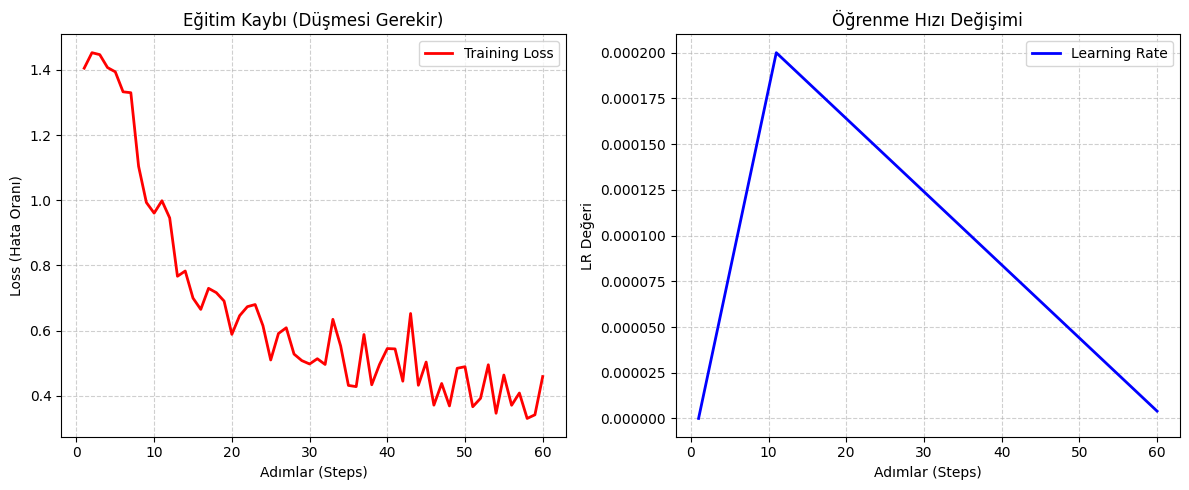

In [2]:
import matplotlib.pyplot as plt

# 1. Log geçmişini çekelim
history = trainer.state.log_history

# Verileri ayrıştıralım
steps = []
losses = []
lr_values = []

for log in history:
    if "loss" in log: # Sadece loss içeren adımları al
        steps.append(log["step"])
        losses.append(log["loss"])
        lr_values.append(log["learning_rate"])

# 2. Grafik Çizimi (Loss Curve)
plt.figure(figsize=(12, 5))

# Sol Grafik: Loss (Kayıp)
plt.subplot(1, 2, 1)
plt.plot(steps, losses, label="Training Loss", color="red", linewidth=2)
plt.xlabel("Adımlar (Steps)")
plt.ylabel("Loss (Hata Oranı)")
plt.title("Eğitim Kaybı (Düşmesi Gerekir)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Sağ Grafik: Learning Rate
plt.subplot(1, 2, 2)
plt.plot(steps, lr_values, label="Learning Rate", color="blue", linewidth=2)
plt.xlabel("Adımlar (Steps)")
plt.ylabel("LR Değeri")
plt.title("Öğrenme Hızı Değişimi")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

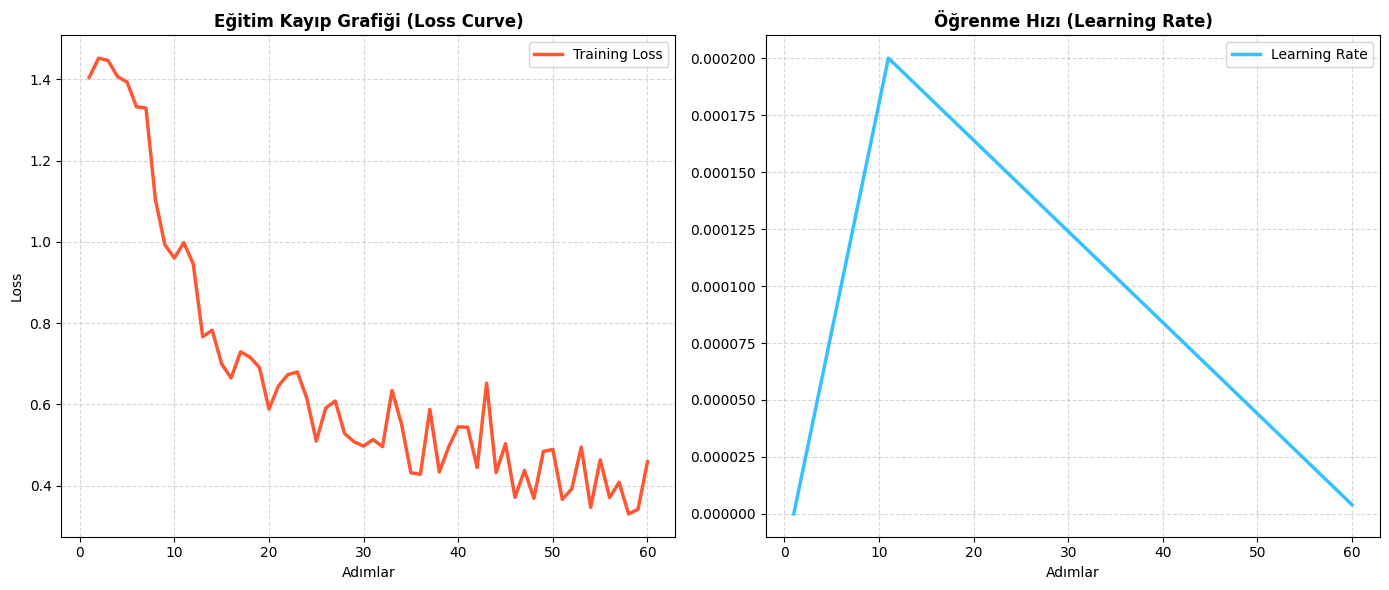

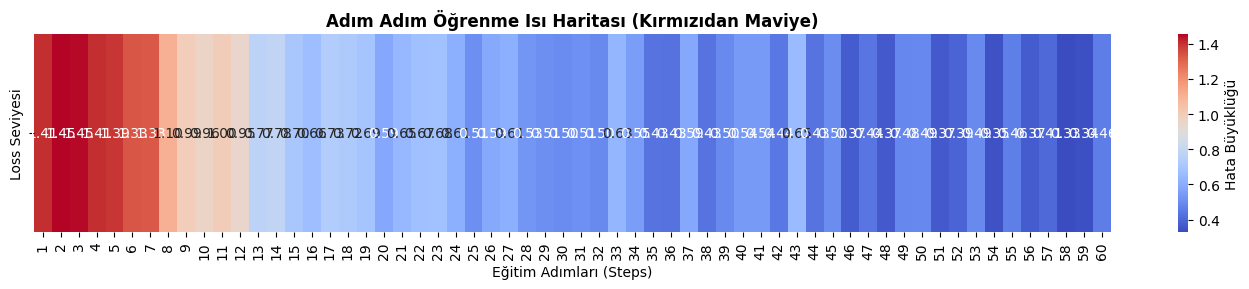

📥 Dosyalar indiriliyor...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from google.colab import files

# 1. Verileri Hazırlayalım (Trainer geçmişinden)
history = trainer.state.log_history
steps = []
losses = []

for log in history:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Pandas DataFrame'e çevirelim (Seaborn için)
df = pd.DataFrame({"Adım": steps, "Loss": losses})

# ==========================================
# 📊 1. KLASİK GRAFİKLER (Line Chart)
# ==========================================
plt.figure(figsize=(14, 6))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(df["Adım"], df["Loss"], label="Training Loss", color="#FF5733", linewidth=2.5)
plt.title("Eğitim Kayıp Grafiği (Loss Curve)", fontsize=12, fontweight='bold')
plt.xlabel("Adımlar", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Learning Rate Grafiği (Eğer varsa)
lr_values = [log["learning_rate"] for log in history if "learning_rate" in log]
if len(lr_values) == len(steps):
    plt.subplot(1, 2, 2)
    plt.plot(steps, lr_values, label="Learning Rate", color="#33C1FF", linewidth=2.5)
    plt.title("Öğrenme Hızı (Learning Rate)", fontsize=12, fontweight='bold')
    plt.xlabel("Adımlar")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

plt.tight_layout()
# Kaydet
plt.savefig("1_egitim_performansi.png", dpi=300)
plt.show()

# ==========================================
# 🔥 2. HEATMAP (Isı Haritası)
# ==========================================
# Loss değerlerini görselleştirmek için bir şerit (Strip) Heatmap yapalım
# Kırmızı = Yüksek Hata (Öğrenemiyor), Mavi = Düşük Hata (Öğrendi)

plt.figure(figsize=(14, 3))
# Veriyi heatmap formatına uygun hale getirelim (Yatay bir çubuk)
loss_matrix = np.array(losses).reshape(1, -1)

sns.heatmap(loss_matrix,
            cmap="coolwarm", # Mavi-Kırmızı renk skalası
            annot=True,      # Değerleri üzerine yaz
            fmt=".2f",       # Virgülden sonra 2 basamak
            xticklabels=steps,
            yticklabels=["Loss Seviyesi"],
            cbar_kws={'label': 'Hata Büyüklüğü'})

plt.title("Adım Adım Öğrenme Isı Haritası (Kırmızıdan Maviye)", fontsize=12, fontweight='bold')
plt.xlabel("Eğitim Adımları (Steps)")
plt.tight_layout()

# Kaydet
plt.savefig("2_loss_heatmap.png", dpi=300)
plt.show()

# ==========================================
# ⬇️ 3. İNDİRME İŞLEMİ
# ==========================================
print("📥 Dosyalar indiriliyor...")
files.download("1_egitim_performansi.png")
files.download("2_loss_heatmap.png")

In [1]:
%%capture
import torch

# 1. Önce PyArrow çakışmasını temizle (Önceki hata için)
!pip install --upgrade --force-reinstall pyarrow
!pip install --upgrade datasets

# 2. Xformers'ı HAZIR PAKET (Binary) olarak zorla yükle
# Bu komut derleme (building wheel) işlemini engeller
try:
    # CUDA 12.1 uyumlu hazır paketi çek
    !pip install xformers --index-url https://download.pytorch.org/whl/cu121 --no-deps
except:
    # Olmazsa standart yüklemeyi dene ama depsiz
    !pip install xformers --no-deps

# 3. Unsloth ve Diğerlerini Kur
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
♻️ Dosyalar Geri Yükleniyor...
   ✅ Model Yüklendi.
   ✅ Test Dosyası Yüklendi.
🔄 Model Hafızaya Alınıyor...
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


🚀 Test Başlıyor! Toplam Soru: 100


Çözülüyor: 100%|██████████| 100/100 [15:18<00:00,  9.19s/it]



🏆 DOĞRULUK ORANI: %53.12


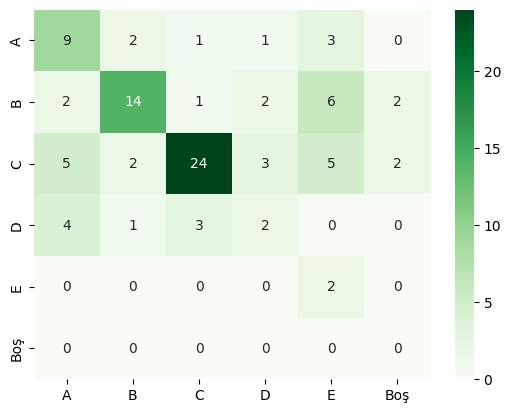

In [1]:


# 2. DRIVE BAĞLANTISI VE DOSYALARI ÇEKME
from google.colab import drive
import shutil
import os
import json
import torch
import re
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from unsloth import FastLanguageModel

drive.mount('/content/drive')

drive_folder = "/content/drive/MyDrive/Proje_Yedekleri"
model_folder = "model_matematik_uzmani"
test_file = "mat_test.json"

print("♻️ Dosyalar Geri Yükleniyor...")

# Modeli Getir
if os.path.exists(f"{drive_folder}/{model_folder}"):
    if os.path.exists(model_folder):
        shutil.rmtree(model_folder)
    shutil.copytree(f"{drive_folder}/{model_folder}", model_folder)
    print("   ✅ Model Yüklendi.")
else:
    print("   ❌ Model Drive'da yok!")

# Test Dosyasını Getir
if os.path.exists(f"{drive_folder}/{test_file}"):
    shutil.copy(f"{drive_folder}/{test_file}", test_file)
    print("   ✅ Test Dosyası Yüklendi.")
else:
    print("   ❌ Test dosyası yok!")

# 3. MODELİ YÜKLE VE TEST ET
print(f"🔄 Model Hafızaya Alınıyor...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_folder,
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model)

# Veriyi Oku
try:
    with open(test_file, 'r', encoding='utf-8') as f:
        test_data = json.load(f)
    print(f"🚀 Test Başlıyor! Toplam Soru: {len(test_data)}")
except:
    test_data = []

# Test Fonksiyonları
prompt_template = """Aşağıdaki matematik sorusunu adım adım düşünerek çöz ve doğru seçeneği belirt.

### Soru:
{}

### Seçenekler:
{}

### Çözüm ve Cevap:
"""

def extract_answer(text):
    match = re.search(r"Doğru Cevap:\s*([A-E])", text, re.IGNORECASE)
    if match: return match.group(1).upper()
    clean = text.strip()
    if clean and clean[-1].upper() in "ABCDE": return clean[-1].upper()
    return "Boş"

# Test Döngüsü
y_true, y_pred = [], []
skipped = 0

if test_data:
    for item in tqdm(test_data, desc="Çözülüyor"):
        q = item.get("question")
        opts = item.get("options")
        corr = item.get("correct")

        if not q or not opts or not corr:
            skipped += 1
            continue

        opts_str = "\n".join([str(x) for x in opts]) if isinstance(opts, list) else str(opts)

        input_text = prompt_template.format(q, opts_str)
        inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

        outputs = model.generate(**inputs, max_new_tokens=512, use_cache=True)
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

        ans = extract_answer(decoded.replace(input_text, ""))
        y_true.append(str(corr).strip().upper())
        y_pred.append(ans)

    if y_true:
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🏆 DOĞRULUK ORANI: %{acc*100:.2f}")

        cm = confusion_matrix(y_true, y_pred, labels=['A','B','C','D','E','Boş'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['A','B','C','D','E','Boş'], yticklabels=['A','B','C','D','E','Boş'])
        plt.show()
    else:
        print("❌ Soru çözülemedi.")
else:
    print("❌ Veri yok.")

In [3]:
import random
import re
import torch

# 1. Eksik Olan Şablon Tanımı
prompt_template_test = """Aşağıdaki matematik sorusunu adım adım düşünerek çöz ve doğru seçeneği belirt.

### Soru:
{}

### Seçenekler:
{}

### Çözüm ve Cevap:
"""

# 2. Cevap Ayıklayıcı Fonksiyon
def extract_answer(generated_text):
    # Önce standart kalıbı ara
    match = re.search(r"Doğru Cevap:\s*([A-E])", generated_text, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    else:
        # Bulamazsan metnin son harfine bak
        clean_text = generated_text.strip()
        if clean_text:
            last_char = clean_text[-1].upper()
            if last_char in ['A', 'B', 'C', 'D', 'E']:
                return last_char
        return "Boş"

# 3. Analiz Döngüsü
# Eğer test_data yüklenmediyse önce onu kontrol et
try:
    if not test_data: raise NameError
except NameError:
    # Test verisi hafızada yoksa dosyadan yükle
    import json
    with open("mat_test.json", "r", encoding="utf-8") as f:
        test_data = json.load(f)

# Rastgele 5 soru seç
sample_data = random.sample(test_data, 5)

print("🔍 MODELİN CEVAPLARI İNCELENİYOR...\n")
print("="*60)

for i, item in enumerate(sample_data):
    question = item.get("question")
    options = item.get("options")
    correct = str(item.get("correct")).strip().upper()

    # Şıkları düzenle
    if isinstance(options, list):
        opts_str = "\n".join([str(x) for x in options])
    else:
        opts_str = str(options)

    # Modele sor
    input_text = prompt_template_test.format(question, opts_str)
    inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

    # Cevap üret
    outputs = model.generate(**inputs, max_new_tokens=256, use_cache=True)
    decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    generated_part = decoded_output.replace(input_text, "").strip()

    # Bizim kodun ne anladığını bul
    predicted = extract_answer(generated_part)

    # --- RAPORU YAZDIR ---
    print(f"SORU {i+1}: {question[:100]}...")
    print(f"DOĞRU CEVAP: {correct}")
    print("-" * 20)
    print(f"📝 MODELİN TAM ÇIKTISI:\n{generated_part}")
    print("-" * 20)
    print(f"🤖 BİZİM KODUN ALGILADIĞI: {predicted}")

    # Karar Anı
    if predicted == correct:
        print("✅ SONUÇ: DOĞRU (Model bilmiş, biz de okumuşuz)")
    elif predicted == "Boş" and correct in generated_part:
        print("⚠️ SONUÇ: FORMAT HATASI! (Model cevabı metin içinde geçirmiş ama kod yakalayamamış)")
    else:
        print("❌ SONUÇ: YANLIŞ (Model gerçekten yanlış çözmüş)")

    print("="*60 + "\n")

🔍 MODELİN CEVAPLARI İNCELENİYOR...

SORU 1: lim_{x→0} (sin(3x))/x değeri kaçtır?...
DOĞRU CEVAP: C
--------------------
📝 MODELİN TAM ÇIKTISI:
x=0 için sin(3x)=0 ve x=0 için x=0 olur. Bu durumda limit 0/0 belirsizliği oluşur. Payı 3x yapalım: lim_{x→0} (sin(3x))/(3x) * 3 = lim_{x→0} (sin(3x))/(3x) * 3 = (lim_{x→0} sin(3x))/(lim_{x→0} 3x) * 3 = (0)/(0) * 3 = 0 olur. Cevap A seçeneğidir.
Doğru Cevap: A
--------------------
🤖 BİZİM KODUN ALGILADIĞI: A
❌ SONUÇ: YANLIŞ (Model gerçekten yanlış çözmüş)

SORU 2: |2x - 3| ≤ 5 eşitsizliğini sağlayan x değerlerinin bulunduğu aralığın uzunluğu kaçtır?...
DOĞRU CEVAP: C
--------------------
📝 MODELİN TAM ÇIKTISI:
|2x - 3| ≤ 5 ⇒ -5 ≤ 2x - 3 ≤ 5. Her tarafa 3 eklenirse: -2 ≤ 2x ≤ 8. Her tarafa 2 bölersek: -1 ≤ x ≤ 4 bulunur. Aralığın uzunluğu 4 - (-1) = 5'tir. Cevap C seçeneğidir.
Doğru Cevap: C
--------------------
🤖 BİZİM KODUN ALGILADIĞI: C
✅ SONUÇ: DOĞRU (Model bilmiş, biz de okumuşuz)

SORU 3: 0 < x < π/2 olmak üzere, tan(x) = 3/4 ise sin(2x) + 

/tmp/ipython-input-4102648365.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=categories, y=values, palette=['gray', '#4CAF50'])


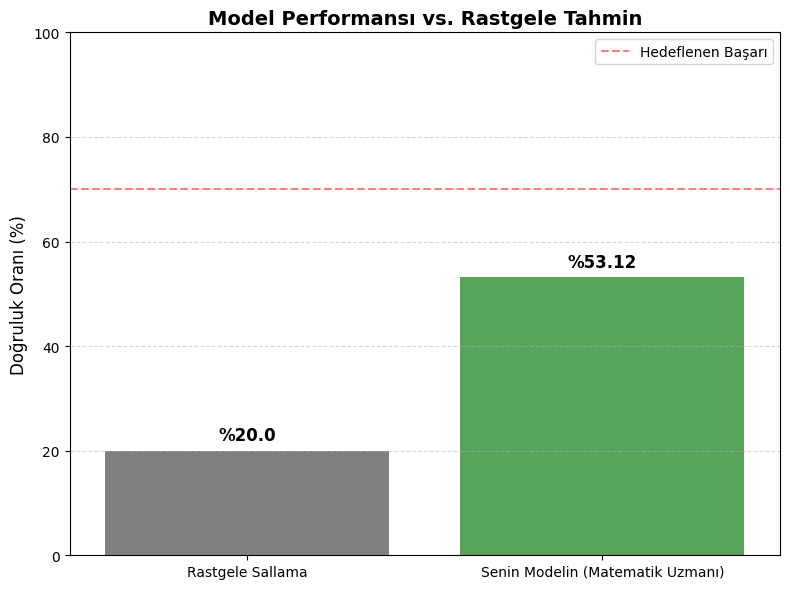

✅ Grafik kaydedildi: 4_matematik_basari_kiyaslamasi.png


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Veriler
categories = ['Rastgele Sallama', 'Senin Modelin (Matematik Uzmanı)']
values = [20.0, 53.12] # Rastgele 5 şıkta %20 şans vardır

plt.figure(figsize=(8, 6))

# Çubuk Grafiği
bars = sns.barplot(x=categories, y=values, palette=['gray', '#4CAF50'])

# Süslemeler
plt.title('Model Performansı vs. Rastgele Tahmin', fontsize=14, fontweight='bold')
plt.ylabel('Doğruluk Oranı (%)', fontsize=12)
plt.ylim(0, 100) # Y ekseni 0-100 arası olsun
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Değerleri çubukların üzerine yaz
for i, v in enumerate(values):
    plt.text(i, v + 2, f"%{v}", ha='center', fontsize=12, fontweight='bold')

# Hedef Çizgisi (%70 diyelim)
plt.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Hedeflenen Başarı')
plt.legend()

plt.tight_layout()
plt.savefig("4_matematik_basari_kiyaslamasi.png", dpi=300)
plt.show()

print("✅ Grafik kaydedildi: 4_matematik_basari_kiyaslamasi.png")